# DEMETER2 in Stan

In [1]:
import pystan
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz
from pathlib import Path
import seaborn as sns

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15

modeling_data_dir = Path('../modeling_data')

## Data preparation

In [2]:
modeling_data = pd.read_csv(modeling_data_dir / 'subset_modeling_data.csv')
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


## Exploratory data analysis

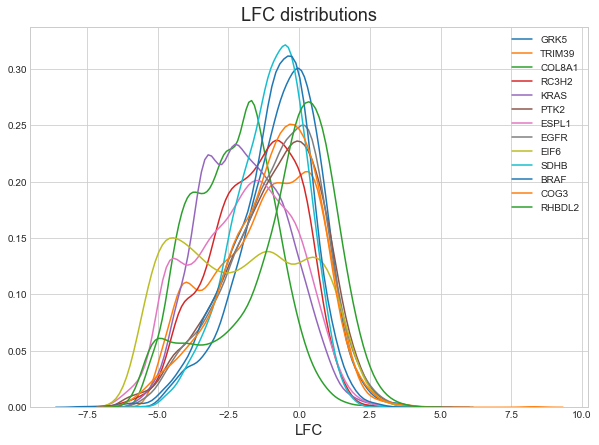

In [3]:
genes = set(modeling_data.gene_symbol.to_list())
for gene in genes:
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=False, label=gene)

plt.title('LFC distributions')
plt.xlabel('LFC')
plt.legend()
plt.show()

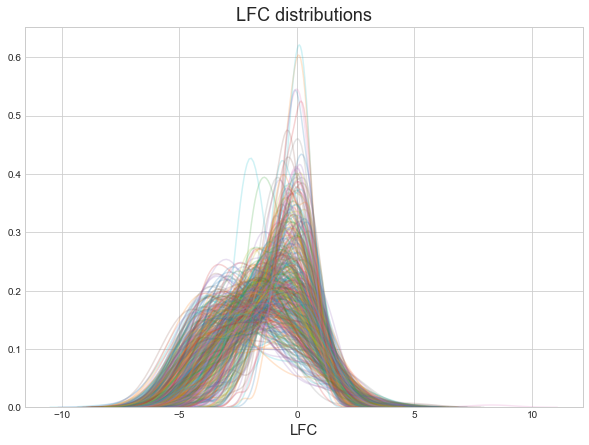

In [4]:
cell_lines = set(modeling_data.cell_line.to_list())
for cell_line in cell_lines:
    lfc = modeling_data[modeling_data.cell_line == cell_line].lfc
    sns.distplot(lfc, kde=True, hist=False, label=None, kde_kws={'alpha': 0.2})

plt.title('LFC distributions')
plt.xlabel('LFC')
plt.show()

In [5]:
modeling_data[['barcode_sequence', 'gene_symbol']].drop_duplicates().groupby('gene_symbol').count()

,barcode_sequence
gene_symbol,
BRAF,8
COG3,5
COL8A1,5
EGFR,19
EIF6,5
ESPL1,5
GRK5,5
KRAS,11
PTK2,23


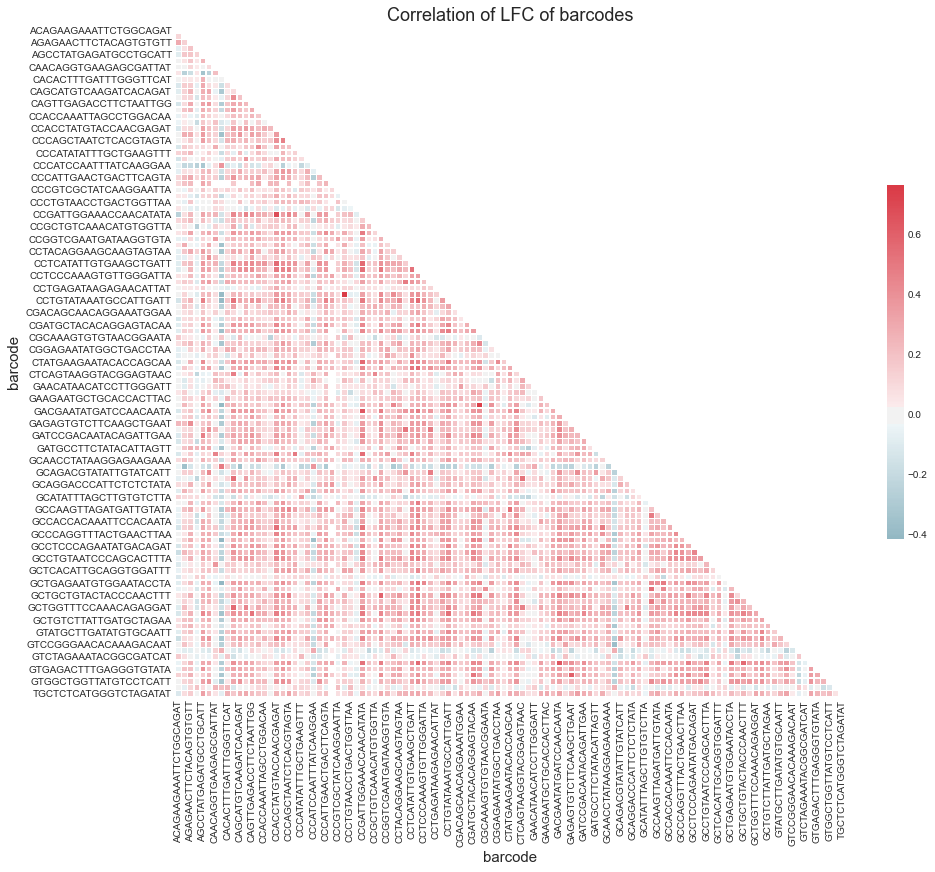

In [6]:
lfc_corr = modeling_data \
    .pivot(index='cell_line', columns='barcode_sequence', values='lfc') \
    .corr()

mask = np.triu(np.ones_like(lfc_corr, dtype=np.bool), k=0)
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(lfc_corr, mask=mask, 
            cmap=cmap, center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
plt.xlabel('barcode')
plt.ylabel('barcode')
plt.title('Correlation of LFC of barcodes')
plt.show()

## Modeling

In [7]:
models_dir = Path('..', 'models')

In [8]:
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


In [9]:
def add_categorical_idx(df, col):
    df[f'{col}_idx'] = df[col].astype('category').cat.codes + 1
    return df

for col in ['barcode_sequence', 'cell_line', 'gene_symbol']:
    modeling_data = add_categorical_idx(modeling_data, col)

modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol,barcode_sequence_idx,cell_line_idx,gene_symbol_idx
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6,1,233,5
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6,1,238,5
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6,1,97,5
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6,1,186,5
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6,1,203,5


In [10]:
d2_stan_data = {
    'N': int(modeling_data.shape[0]),
    'I': len(np.unique(modeling_data.barcode_sequence_idx)),
    'J': len(np.unique(modeling_data.cell_line_idx)),
    'K': len(np.unique(modeling_data.batch)),
    'L': len(np.unique(modeling_data.gene_symbol_idx)),
    
    'cell_line': modeling_data.cell_line_idx,
    'batch': modeling_data.batch,
    
    'y': modeling_data.lfc,
}

In [11]:
d2_stan_file = models_dir / 'd2_stan_model_1.stan'
d2_stan_model = pystan.StanModel(file=d2_stan_file.as_posix())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c09d2794a076bd6ccd7d58bc741e7b05 NOW.


In [12]:
d2_stan_fit = d2_stan_model.sampling(data=d2_stan_data, iter=1000, chains=2)

Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Caskroo

KeyboardInterrupt: 

Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Caskroom/miniconda/base/envs/demeter2-stan-demo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Caskro

In [ ]:
d2_stan_fit